In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
from random import sample
from skimage import io
import pydicom
from PIL import Image

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
85159,00020995_002.png,No Finding,2,20995,30,M,PA,3056,2452,0.139,0.139,NaN
11985,00003126_008.png,Infiltration|Pneumothorax,8,3126,78,F,AP,3056,2544,0.139,0.139,NaN
66676,00016486_013.png,Effusion,13,16486,34,F,PA,2992,2991,0.143,0.143,NaN


In [3]:
## Load sample data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2889,00014253_051.png,Effusion,51,14253,061Y,M,AP,2500,2048,0.168,0.168
4016,00019786_001.png,Mass,1,19786,046Y,F,PA,2992,2991,0.143,0.143
1431,00007430_002.png,No Finding,2,7430,026Y,M,AP,2500,2048,0.168,0.168


In [4]:
## EDA

## Splitting "Finding Labels" column into one column per disease, with a binary flag.
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5877,00001582_018.png,Cardiomegaly|Effusion,18,1582,34,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37399,00009863_044.png,Pneumothorax,44,9863,40,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12740,00003348_001.png,Pneumothorax,1,3348,46,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


(array([  425.,  1742.,  3074.,  6309.,  8072., 10102.,  9840., 13302.,
        15215., 16991., 13091.,  8149.,  4071.,  1347.,   309.,    65.,
            0.,     0.,     0.,     0.]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120.]),
 <a list of 20 Patch objects>)

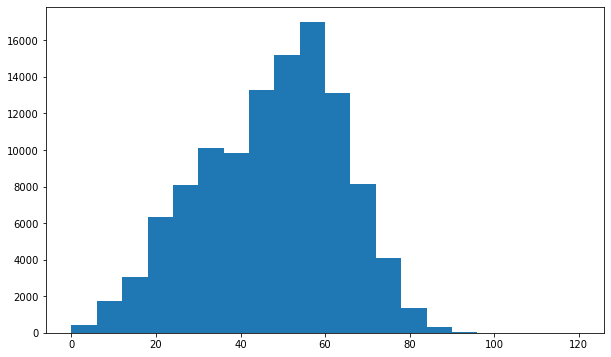

In [5]:
## EDA-1: Distribution of age across the dataset.
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], range=(0, 120), bins=20)

(array([ 13.,  33.,  62.,  90., 118., 152., 128., 144., 177., 181., 159.,
        115.,  40.,  14.,   3.,   1.,   0.,   0.,   0.,   0.]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120.]),
 <a list of 20 Patch objects>)

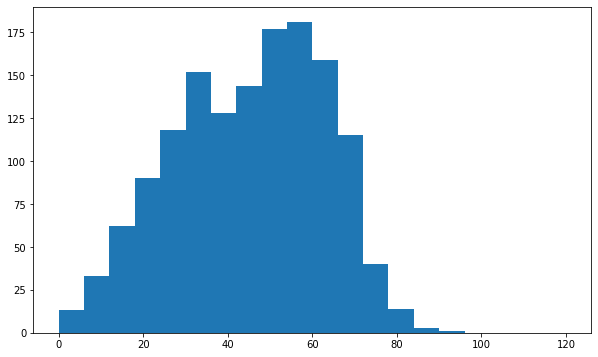

In [6]:
## EDA-1: Distribution of age for Pneumonia
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], range=(0, 120), bins=20)

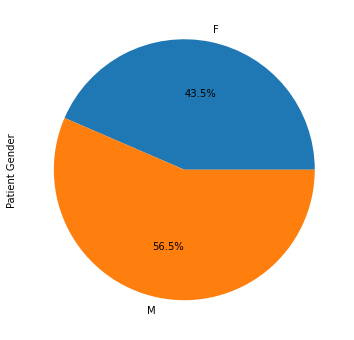

In [7]:
## EDA-1: Distribution of gender dacross the dataset.
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].str.get_dummies().sum().plot.pie(label='Patient Gender', autopct='%1.1f%%')

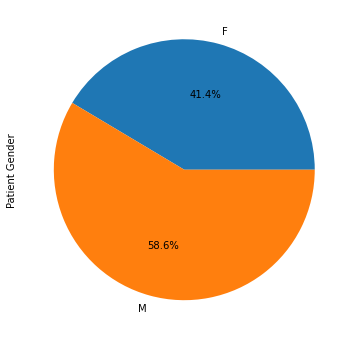

In [8]:
## EDA-1: Distribution of gender for Pneumonia.
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].str.get_dummies().sum().plot.pie(label='Patient Gender', autopct='%1.1f%%')

### EDA-1 Conclusions

Age is normally distributed across the data set and the pneumonia data set, implying that training and testing data can be selected randomly from the total patient population.

Patient gender is split approximately 60:40 in favour of men for both total and pneumonia data sets. Again, no special considerations need be made when creating training and testing data.

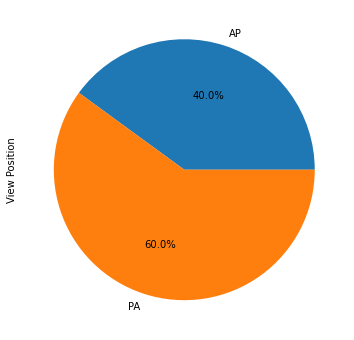

In [9]:
## EDA-2: Distribution of x-ray views (view position) across the dataset.
plt.figure(figsize=(6,6))
all_xray_df['View Position'].str.get_dummies().sum().plot.pie(label='View Position', autopct='%1.1f%%')

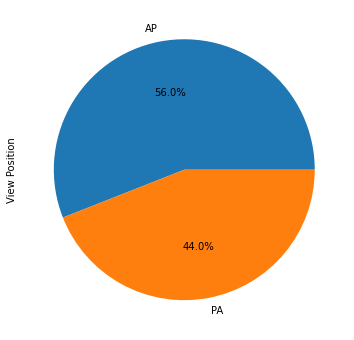

In [10]:
## EDA-2: Distribution of x-ray views (view position) for Pneumonia.
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].str.get_dummies().sum().plot.pie(label='View Position', autopct='%1.1f%%')

### EDA-2 Conclusions

View position appears to have a greater distribution for AP for pneumonia as it does for non-pneumonia coases. This makes sense given the focus on the lungs which are more easily viewed from an 'AP' position.

In [ ]:
## EDA-3: The number of pneumonia cases and non-pneumonia cases
counts = all_xray_df['Pneumonia'].value_counts()

print("Number of total cases: {}".format(len(all_xray_df)))
print("Number, percentage of pneumonia cases: {}, {}".format(counts[1], counts[1] / len(all_xray_df)))
print("Number, percentage of non-pneumonia cases: {}, {}".format(counts[0], counts[0] / len(all_xray_df)))

In [12]:
## EDA-3: The number of total cases
len(all_xray_df)

112120

### EDA-3 Conclusions
Pneumonia represents about 1.3% of all cases in the data set. This will be important information to use when developing train and validation sets.

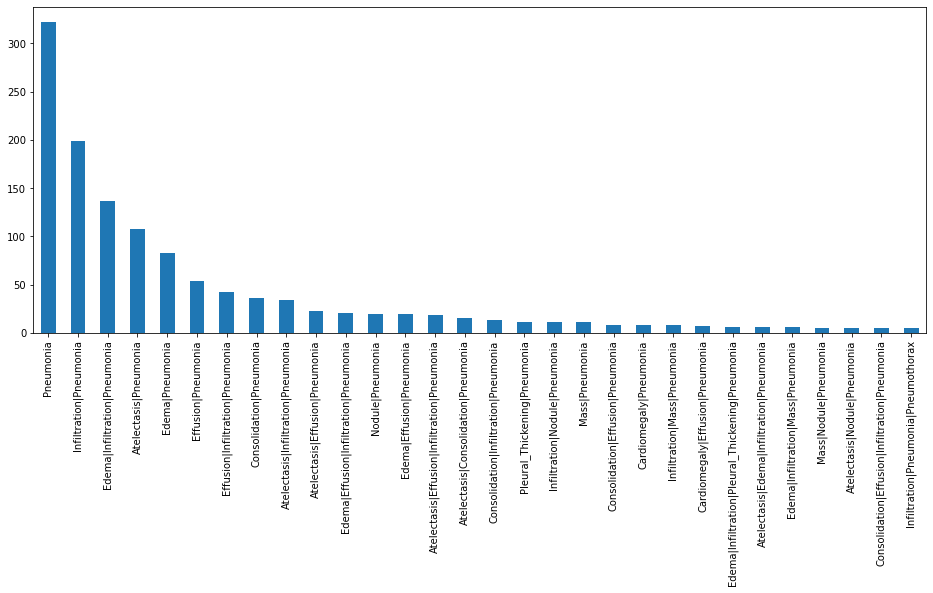

In [13]:
## EDA-4: The distribution of other diseases that are comorbid with pneumonia
## Top 30 most common co-occurrences for Pneumonia:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')


### EDA-4 Conclusions

Pneumonia has significant co-morbidities, including Infiltration, Edema and Atelectasis. It might be useful to explore whether the prior presence of these diseases can help to improve detection of pneumonia.

(array([6.0361e+04, 3.0963e+04, 1.4306e+04, 4.8560e+03, 1.2470e+03,
        3.0100e+02, 6.7000e+01, 1.6000e+01, 1.0000e+00, 2.0000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

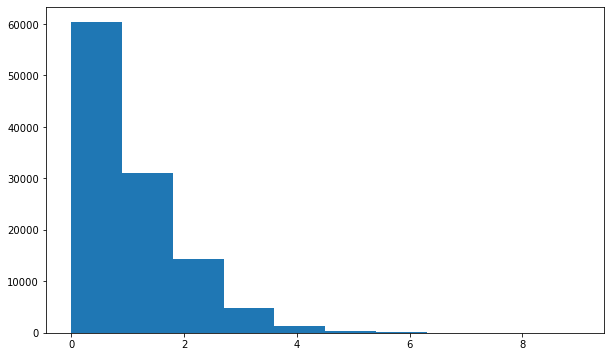

In [14]:
## EDA-5: Number of diseases per patient.
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',\
                  'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',\
                  'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
all_xray_df['Disease Total'] = all_xray_df.loc[:, disease_labels].sum(axis=1)
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Disease Total'])

(array([322., 544., 386., 138.,   0.,  34.,   3.,   3.,   0.,   1.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

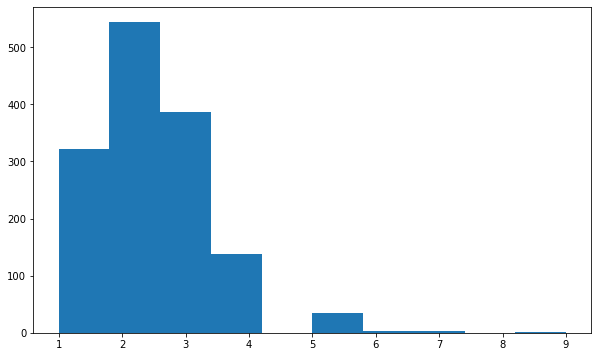

In [15]:
## EDA-5: Number of diseases per patient when Pneumonia present.
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Disease Total'])

### EDA-5 Conclusions

There's a higher rate of co-morbidities for pneumonia patients than for the general patient population. This could lead to using the presence of other diseases to help in classifying the presence of pneumonia.


No Finding


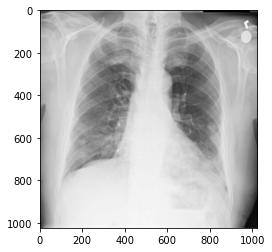

In [16]:
## EDA-6 Pixel-level assessments of the imaging data for healthy & disease states of interest 
## (e.g. histograms of intensity values) and compare distributions across diseases.

## Visualize test image
dcm = pydicom.dcmread('test1.dcm')
plt.imshow(dcm.pixel_array,cmap='gray')
print(dcm.StudyDescription)

Text(0.5, 1.0, 'Image Pixel Intensity')

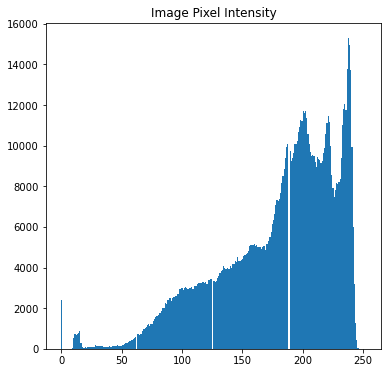

In [17]:
## EDA-6 Intensity histogram of test image
plt.figure(figsize=(6,6))
plt.hist(dcm.pixel_array.ravel(), bins = 256)
plt.title('Image Pixel Intensity')

mean intensity: 180.0586576461792
std intensity: 47.89115072730743


Text(0.5, 1.0, 'Normalized Image Pixel Intensity')

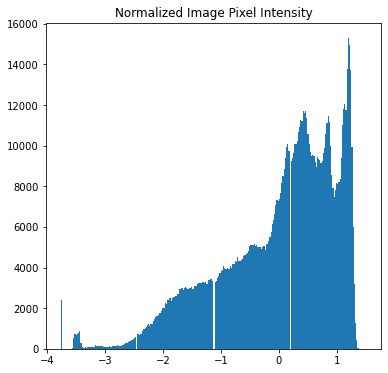

In [18]:
## EDA-6 Normalized intensity histogram of test image
mean_intensity = np.mean(dcm.pixel_array)
print("mean intensity:", mean_intensity)
std_intensity = np.std(dcm.pixel_array)
print("std intensity:",std_intensity)
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
plt.figure(figsize=(6,6))
plt.hist(new_img.ravel(), bins = 256)
plt.title('Normalized Image Pixel Intensity')

00008470_008.png
00011702_043.png
00012158_025.png
00012667_000.png
00012733_000.png
00014201_008.png
00017714_019.png
00019021_001.png
00019865_013.png
00021127_018.png
00022192_032.png
00022877_014.png
00026179_003.png
00028924_005.png


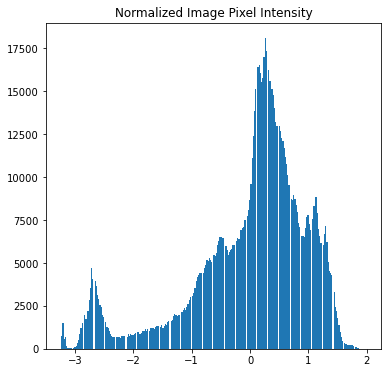

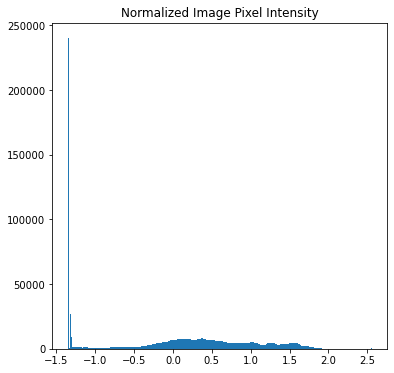

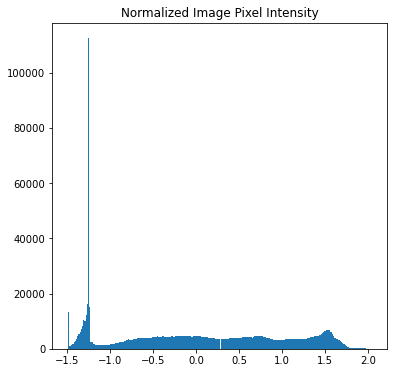

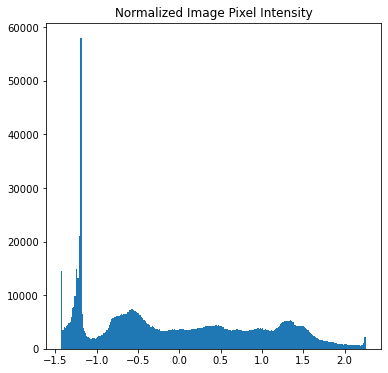

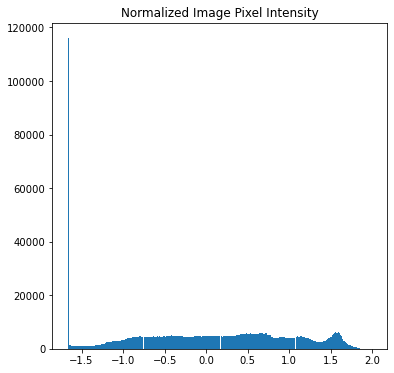

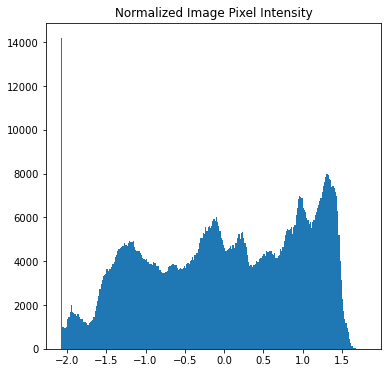

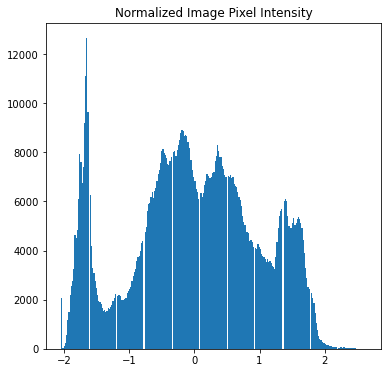

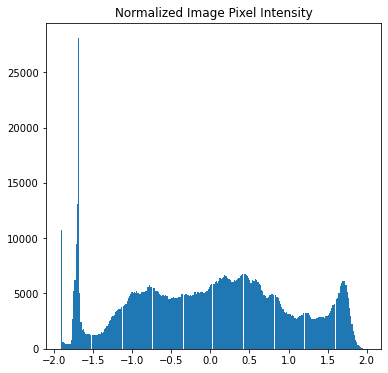

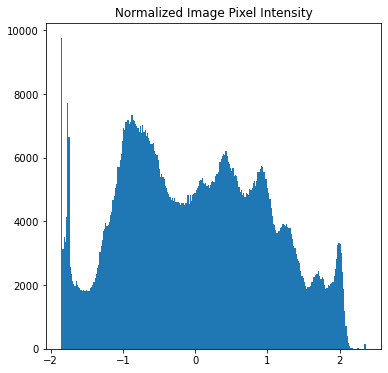

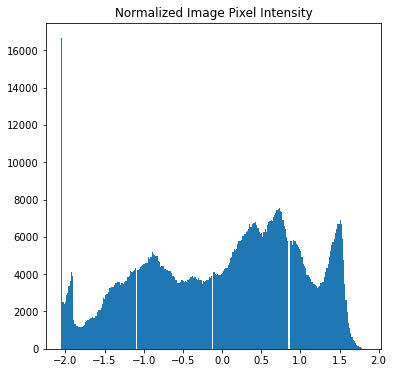

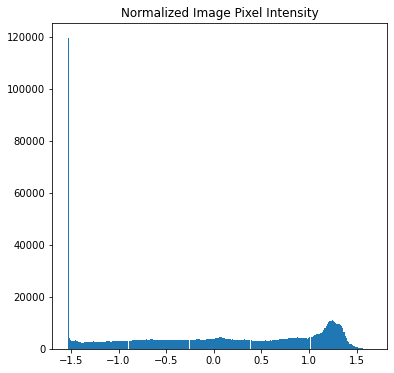

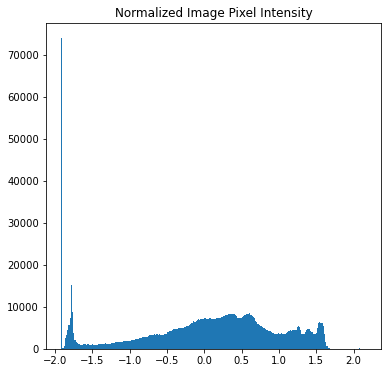

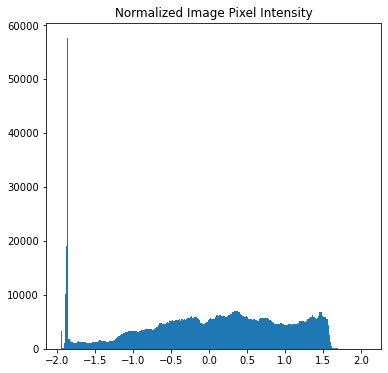

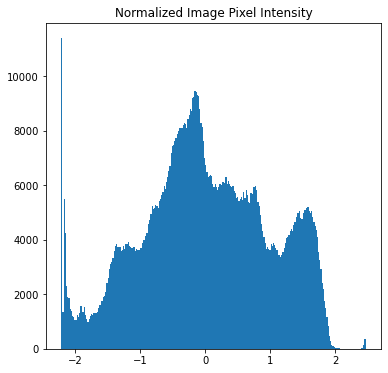

In [19]:
## EDA-6 Normalized intensity histogram of Pneumonia images
bbox = pd.read_csv('/data/BBox_List_2017.csv')
pneumonia_df = sample_df[sample_df['Finding Labels'] == "Pneumonia"]

def find_file(img):
    import os
    file_loc = {}
    for dirs,subdirs, files in os.walk('/data/'):
        for file in files:
            file_loc[file] = os.path.join(dirs, file)
    return file_loc[img]

for i in range(len(pneumonia_df)):
    img = Image.open(find_file(pneumonia_df["Image Index"].iloc[i]))
    print(pneumonia_df["Image Index"].iloc[i])
    
    pixels = np.array(img.getdata())

    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    new_img = pixels.copy()
    new_img = (new_img - mean_intensity)/std_intensity

    plt.figure(figsize=(6,6))
    plt.hist(new_img.ravel(), bins = 256)
    plt.title('Normalized Image Pixel Intensity')

00000017_001.png
00000042_002.png
00000057_001.png
00000061_019.png
00000080_005.png
00000083_000.png
00000099_006.png
00000121_004.png
00000165_008.png
00000188_001.png


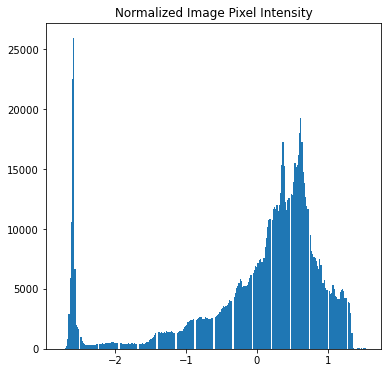

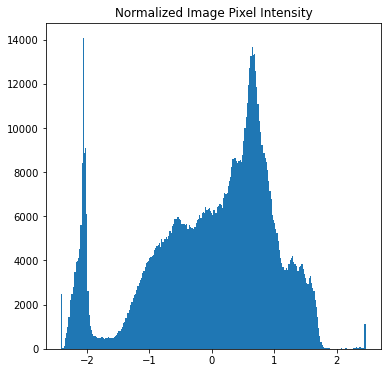

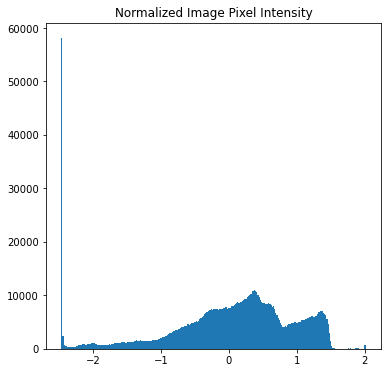

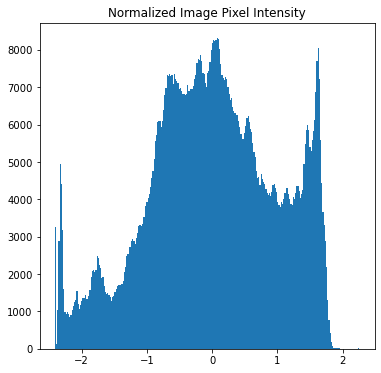

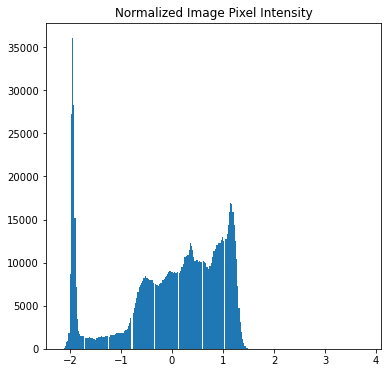

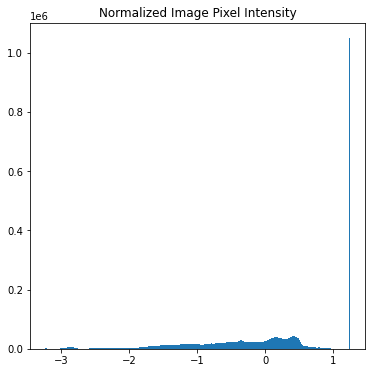

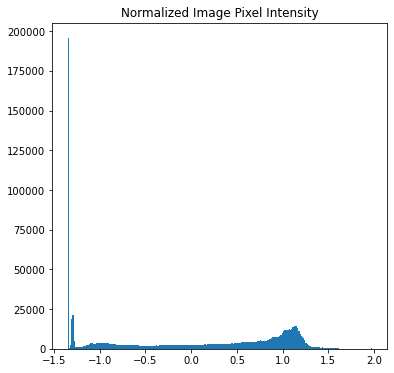

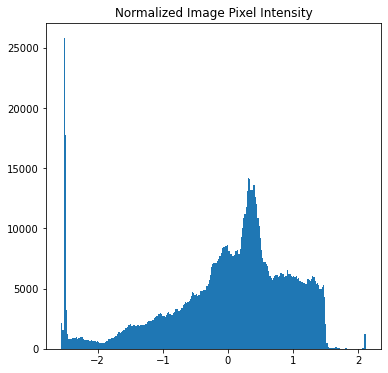

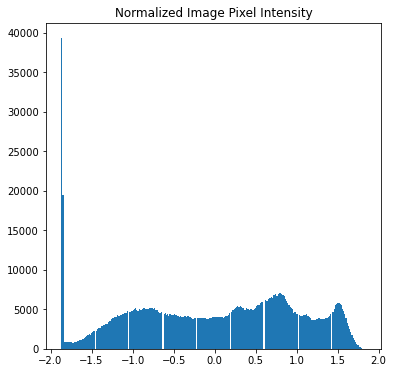

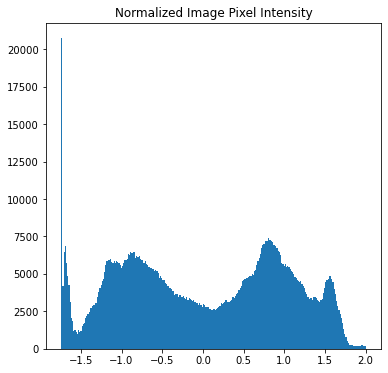

In [20]:
## EDA-6 Normalized intensity histogram of Normal images
bbox = pd.read_csv('/data/BBox_List_2017.csv')
normal_df = sample_df[sample_df['Finding Labels'] == "No Finding"]

def find_file(img):
    import os
    file_loc = {}
    for dirs,subdirs, files in os.walk('/data/'):
        for file in files:
            file_loc[file] = os.path.join(dirs, file)
    return file_loc[img]

for i in range(min(10, len(normal_df))):
    img = Image.open(find_file(normal_df["Image Index"].iloc[i]))
    print(normal_df["Image Index"].iloc[i])
    
    pixels = np.array(img.getdata())

    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    new_img = pixels.copy()
    new_img = (new_img - mean_intensity)/std_intensity

    plt.figure(figsize=(6,6))
    plt.hist(new_img.ravel(), bins = 256)
    plt.title('Normalized Image Pixel Intensity')

### EDA-6 Conclusions

There are a significant number of 'dark' pixels in many of the images, which may lead to lower classification accuracy. Pre-processing of images might include application of Otsu's method to set a cut-off to exclude these pixels.

It also appears that the mean intensity for pneumonia images is significantly higher than for non-pneumonia patients, which makes sense considering the the presence of pneumonia brightens the image.